# load modules

In [385]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 19 04:32:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0 Off |                  N/A |
| 45%   21C    P8    11W / 350W |   3607MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [386]:
import pandas as pd
import numpy as np
import torch

print("PyTorch has version {}".format(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

PyTorch has version 1.10.0
cuda


In [387]:
!nvcc --version

/bin/bash: nvcc: command not found


# load dataset

In [388]:
! pwd

/home/jihun/python


In [389]:
# to make a training dataframe that 'positive' is labeled as 1 and 'negative' as 0
# initialize a training dataframe
column_names = ['sentence', 'label']
train_df = pd.DataFrame(columns = column_names)

import os
for dirname, _, filenames in os.walk('/home/jihun/python/data_nlp/train/positive'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        f = open(path, 'r')
        line = f.readline()
        input_df = pd.DataFrame.from_dict([{'sentence': line, 'label': 1 }])
        train_df = pd.concat([train_df, input_df], axis=0)
        f.close
        
for dirname, _, filenames in os.walk('/home/jihun/python/data_nlp/train/negative'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        f = open(path, 'r')
        line = f.readline()
        input_df = pd.DataFrame.from_dict([{'sentence': line, 'label': 0 }])
        train_df = pd.concat([train_df, input_df], axis=0)
        len(train_df)
        f.close
train_df.index = [k for k in range(2000)]

In [390]:
# to make a training dataframe that 'positive' is labeled as 1 and 'negative' as 0
# initialize a training dataframe
column_names = ['sentence']
test_df = pd.DataFrame(columns = column_names)

import os
for dirname, _, filenames in os.walk('data_nlp/test'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        f = open(path, 'r')
        line = f.readline()
        input_df = pd.DataFrame.from_dict([{'sentence': line}])
        test_df = pd.concat([test_df, input_df], axis=0)
        f.close
test_df.index = [k for k in range(len(test_df))]

In [391]:
print("the total number of examples : ", len(train_df))
print("the total number of positive examples : ", len(train_df[train_df['label']==1]))
print("the total number of negative examples : ", len(train_df[train_df['label']==0]))
print("the ratio of positive examples to negative examples : ", len(train_df[train_df['label']==1])/len(train_df[train_df['label']==0]))

the total number of examples :  2000
the total number of positive examples :  1000
the total number of negative examples :  1000
the ratio of positive examples to negative examples :  1.0


In [392]:
# total number of the words
print("Total number of the words: ")
print(train_df['sentence'].apply(lambda x: len(x.split(' '))))

# the average length of a document
print("\nThe average number of the words: ")
print(train_df['sentence'].apply(lambda x: len(x.split(' '))).mean())

# the max length of a document
print("\nThe max number of the words: ")
print(train_df['sentence'].apply(lambda x: len(x.split(' '))).max())

Total number of the words: 
0       194
1        44
2       185
3        38
4       189
       ... 
1995    177
1996     47
1997     99
1998    126
1999     98
Name: sentence, Length: 2000, dtype: int64

The average number of the words: 
187.677

The max number of the words: 
3816


In [393]:
print(train_df['sentence'].apply(pd.Series).stack().reset_index(drop=True))
print(type(train_df['sentence'].apply(pd.Series).stack().reset_index(drop=True)))

0       greatest spy thriller this is the true account...
1       rick steves books are the best i love the way ...
2       fascinating as a geography and history buff , ...
3       plymoth we were very pleased with our books . ...
4       is it reality or a blend of reality and fantas...
                              ...                        
1995    dumb this is one of the stupidest books i have...
1996    buyer beware after reading this dull uninforma...
1997    not worth the money this book is only low to m...
1998    a step back i have been reading this book for ...
1999    the missing element an excellent and important...
Length: 2000, dtype: object
<class 'pandas.core.series.Series'>


In [394]:
# the total number of unique words in T
len(list(set(' '.join(train_df['sentence']).split(' '))))

24473

In [395]:
train_df_word = train_df['sentence'].apply(lambda x:x.split(' '))
print(train_df_word)
print(type(type(train_df_word)))

test_df_word = test_df['sentence'].apply(lambda x:x.split(' '))

0       [greatest, spy, thriller, this, is, the, true,...
1       [rick, steves, books, are, the, best, i, love,...
2       [fascinating, as, a, geography, and, history, ...
3       [plymoth, we, were, very, pleased, with, our, ...
4       [is, it, reality, or, a, blend, of, reality, a...
                              ...                        
1995    [dumb, this, is, one, of, the, stupidest, book...
1996    [buyer, beware, after, reading, this, dull, un...
1997    [not, worth, the, money, this, book, is, only,...
1998    [a, step, back, i, have, been, reading, this, ...
1999    [the, missing, element, an, excellent, and, im...
Name: sentence, Length: 2000, dtype: object
<class 'type'>


Padding

In [396]:
def add_padding(token_ls, max_len):
    for index, tokens in enumerate(token_ls):
        n_token = len(tokens)
        pad = '<PAD>'
        # add padding if the length is shorter than max_len
        if n_token < max_len:
            token_ls[index] += [pad] * (max_len - n_token) # 부족한 만큼 padding을 추가함
        
        # if a sentence is longer than max_len, cut a sentence.
        elif n_token > max_len:
            token_ls[index] = tokens[:max_len]
    return token_ls

In [397]:
train_df_input = train_df.copy()
max_length = 1000
train_df_input['sentence'] = add_padding(train_df_word, max_length)
print(train_df_input)

test_df_input = test_df.copy()
test_df_input['sentence'] = add_padding(test_df_word, max_length)
test_df_input

                                               sentence label
0     [greatest, spy, thriller, this, is, the, true,...     1
1     [rick, steves, books, are, the, best, i, love,...     1
2     [fascinating, as, a, geography, and, history, ...     1
3     [plymoth, we, were, very, pleased, with, our, ...     1
4     [is, it, reality, or, a, blend, of, reality, a...     1
...                                                 ...   ...
1995  [dumb, this, is, one, of, the, stupidest, book...     0
1996  [buyer, beware, after, reading, this, dull, un...     0
1997  [not, worth, the, money, this, book, is, only,...     0
1998  [a, step, back, i, have, been, reading, this, ...     0
1999  [the, missing, element, an, excellent, and, im...     0

[2000 rows x 2 columns]


,sentence
0,"[good, history, ,, but, ..., ..., ., no, doubt..."
1,"[i, completely, agree, i, completely, agree, ,..."
2,"[vsm, for, the, office, i, found, this, to, be..."
3,"[could, n't, finish, it, ., i, first, read, cl..."
4,"[dutch, oven, use, and, care, ,, plus, varied,..."
...,...
1995,"[a, good, book, is, hard, to, find, i, picked,..."
1996,"[a, classical, if, a, bit, dated, primer, on, ..."
1997,"[return, of, charles, johnson, mr., gilkerson,..."
1998,"[look, for, teach, yourself, catalan, in, rece..."


Pre-training

In [398]:
# to read pre-training file
file_path = os.path.join("data_nlp/all.review.vec.txt")

word_to_ix = {}
embedding_dictionary = {}
with open(file_path) as file:
    for index, line in enumerate(file):
        word, coefficient = line.split(maxsplit=1)
        coefficient = np.fromstring(coefficient, "f", sep=" ")
        word_to_ix[word] = index+2
        embedding_dictionary[word] = coefficient
word_to_ix['<unk>']= 0
word_to_ix['<pad>']= 1
        
embedding_dictionary.pop('56050') # remove the hdeader
print("Found %s word vectors." % len(embedding_dictionary))
print(type(embedding_dictionary))

Found 56050 word vectors.
<class 'dict'>


In [399]:
# to convert the data type of embedding_matrix (dictionary) into numpy array
#embedding_matrix = np.array(list(map(lambda x: x.split(' '), list(embedding_dictionary.values())))) # parsing the 1-dimensioal array into 2-dimensional array
#embedding_matrix = embedding_matrix[:,:-1] #drop the '\n'
#embedding_matrix = embedding_matrix.astype('float32')
embedding_matrix = np.array(list(embedding_dictionary.values()))
print(embedding_matrix.shape)

(56050, 100)


In [400]:
def sequence_to_index(sequence, embedding_index):
    converted_index = [embedding_index[word] if word in embedding_index.keys() else embedding_index['<unk>'] for word in sequence]
    return converted_index
    #return torch.tensor(converted_index, dtype=torch.long)

#example
sequence_to_index([',', 'king', 'strainge_wrod_hahahahaha'], word_to_ix)

[5, 570, 0]

In [401]:
test_df_input.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
           dtype='int64', length=2000)

In [402]:
train_df_tensor_x = torch.tensor(list(map(lambda x: sequence_to_index(x, word_to_ix), train_df_input['sentence'])))
train_df_tensor_y = torch.tensor(train_df_input['label'])

test_df_tensor_x = torch.tensor(list(map(lambda x: sequence_to_index(x, word_to_ix), test_df_input['sentence'])))
test_df_tensor_y = torch.tensor(train_df_input.index)

In [403]:
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader
from torch.utils.data import random_split

total_train_dataset = TensorDataset(train_df_tensor_x, train_df_tensor_y)
test_dataset = TensorDataset(test_df_tensor_x, test_df_tensor_y) #this label is fake.for data in testloader:

train_dataset, validation_dataset = random_split(total_train_dataset, [int(len(total_train_dataset)*0.8), len(total_train_dataset)-int(len(total_train_dataset)*0.8)])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32)


print(len(total_train_dataset))
print(len(train_dataset))
print(len(validation_dataset))
print(len(validation_dataset))
print(len(test_dataset))

2000
1600
400
400
2000


# Module for training

In [404]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    predicted = torch.argmax(preds, dim=1)
    correct = (predicted == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [405]:
# to measure the running time
import time

# CNN with pretraining

Ref :
- https://wikidocs.net/80437
- https://wikidocs.net/80783
- https://sanghyu.tistory.com/24
- https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
- https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html

In [406]:
m = nn.Conv1d(1, 50, (200, 3)) # in_channel x out_channel x (kernel_size, embed_size)
input = torch.randn(32, 1, 200, 100) # batch(#sentence) x in_channel x max_num_word x embed_size
output = m(input) # batch x out_channel x 1 x L_out (the changed embeded_size)
print(output.size())

torch.Size([32, 50, 1, 98])


In [407]:
m = nn.Conv1d(100, 2, 3) #embed_size x num_filter x kernel_size 
# in_channel x out_channel x (kernel_size, embed_size)
input = torch.randn(32, 100, 200) # batch(#sentence) x embed_size x max_num_word
output = m(input) # batch x num_filter x L_out (the changed embeded_size)
output.size()

torch.Size([32, 2, 198])

In [408]:
m = nn.MaxPool1d(198)
input = torch.randn(32, 2, 198) # batch_size x num_filter x out_channel
output = m(input)
print(output.size()) # batch_size x num_filter x max_pool_out_channel

torch.Size([32, 2, 1])


In [409]:
class CNN(nn.Module):
    def __init__(self, batch_size, voca_size, embed_size, pad_index, hidden_unit, drop_rate=0.3, kernel_size=3, num_filter=100, n_class=2):
        super(CNN, self).__init__()
        self.batch_size = batch_size
        self.pad_index = pad_index  # padding token
        self.embed_size = embed_size            # 임베딩 차원의 크기
        self.hidden_unit = hidden_unit           # 히든 레이어 갯수
        self.drop_rate = drop_rate              
        self.num_filter = num_filter            # 필터의 갯수 
        self.kernel_size = kernel_size          # 필터 사이즈
        self.n_class = n_class
        
        self.word_embeddings = nn.Embedding(
            num_embeddings=voca_size, embedding_dim=embed_size, padding_idx=self.pad_index
        )
        
        # kernel size = (n-gram, embed_size)
        # 커널의 열(column)의 크기는 embed_size와 일치하므로, 단어 임베딩 벡터를 모두 커버한다
        # 따라서, n의 row 크기를 갖는 커널은 한번에 n개의 단어를 커버하는 n-gram 커널이라고 볼 수 있다.
        self.conv1d = nn.Conv1d(embed_size, self.num_filter, self.kernel_size)
        self.lin = nn.Linear(num_filter, n_class)

        
    def forward(self, x):
        # x : batch_size x max_length
        
        embed = self.word_embeddings(x) 
        # embed : batch_size x max_length x embed_size
        embed = torch.reshape(embed, (self.batch_size, self.embed_size, -1))
        conv_out = self.conv1d(embed)
        # conv_out : batch_size x num_filter x the_changed_embedded_size
        #print("conv_out", conv_out.size())
        pool_out = F.max_pool1d(kernel_size= conv_out.size(2), input= conv_out)
        #print("pool_out", pool_out.size()) 
        # pool_out : batch_size x num_filter x 1
        pool_out = torch.reshape(pool_out, (self.batch_size, self.num_filter))
        out = self.lin(pool_out)

        return out

In [410]:
params = {
    'batch_size' : 32,
    'voca_size' : len(word_to_ix),        # 고유한 단어 토큰의 갯수
    'embed_size' : 100,                # 임베딩 차원의 크기
    'pad_index' : word_to_ix['<pad>'],  # 패딩 토큰
    'hidden_unit' : 50,                  # 히든 레이어 갯수 #???
    'drop_rate' : 0.1, 
    'kernel_size' : 3,    
    'num_filter' : 2,                 # 각 사이즈 별 커널 갯수 (원문에서는 100을 사용)
    'n_class' : 2,                  # 카테고리 갯수
}

In [411]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_CNN = CNN(**params)
model_CNN.word_embeddings.weight.data = torch.FloatTensor(embedding_matrix)
model_CNN.word_embeddings.weight.requires_grad = False #embedding weights are fixed. (not updated)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_CNN.parameters(), lr=0.1)

In [412]:
#CPU
total_time_start = time.time()

total_epoch = 40
total_train_loss= np.array([])
total_train_accuracy= np.array([])
total_val_loss=np.array([])
total_val_accuracy= np.array([])

#start_word_embeddingstime=time.time()
for epoch in range(total_epoch) :
    epoch_train_loss=0
    epoch_train_accuracy=np.array([])
    epoch_val_loss=0
    epoch_val_accuracy=np.array([])

    
    # train
    model_CNN.train()
    for batch_idx, batch in enumerate(train_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        #print(x_train.size())
        predicted_y = model_CNN(x_train).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        #print(predicted_y)    
        #print(label)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        loss.backward() # compute the gradients
        optimizer.step() # update the parameters
        epoch_train_loss += loss.item()
        acc = binary_accuracy(predicted_y, label) # to measure accuracy
        epoch_train_accuracy = np.append(epoch_train_accuracy, [acc])
        
    # validation
    model_CNN.eval()
    total_val_error=0
    for batch_idx, batch in enumerate(validation_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        predicted_y = model_CNN(x_train).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        epoch_val_loss += loss.item()   
        acc = binary_accuracy(predicted_y, label) # to measure accuracy
        epoch_val_accuracy = np.append(epoch_val_accuracy, [acc])
    
    
    total_train_loss = np.append(total_train_loss, [epoch_train_loss/len(train_loader.dataset)])
    total_train_accuracy= np.append(total_train_accuracy, [sum(epoch_train_accuracy)/len(epoch_train_accuracy)])
    total_val_loss = np.append(total_val_loss, [epoch_val_loss/len(validation_loader.dataset)])
    total_val_accuracy = np.append(total_val_accuracy, [sum(epoch_val_accuracy)/len(epoch_val_accuracy)])
    
    print("[{:02d}/{:02d}] \t loss: {:.10f}\t val_error: {:.10f}\t val_accuracy : {:10f}".format(epoch, total_epoch, epoch_train_loss / len(train_loader.dataset), epoch_val_loss / len(validation_loader.dataset), sum(epoch_val_accuracy)/len(epoch_val_accuracy)))

total_time_end = time.time()
print("total running time: ", total_time_end - total_time_start)

[00/40] 	 loss: 0.0219399252	 val_error: 0.0208654608	 val_accuracy :   0.497396
[01/40] 	 loss: 0.0216661705	 val_error: 0.0208066747	 val_accuracy :   0.494792
[02/40] 	 loss: 0.0216181434	 val_error: 0.0207550569	 val_accuracy :   0.536458
[03/40] 	 loss: 0.0216053389	 val_error: 0.0207850355	 val_accuracy :   0.526042
[04/40] 	 loss: 0.0215792892	 val_error: 0.0207598098	 val_accuracy :   0.531250
[05/40] 	 loss: 0.0215664021	 val_error: 0.0207841271	 val_accuracy :   0.520833
[06/40] 	 loss: 0.0215496726	 val_error: 0.0207839257	 val_accuracy :   0.497396
[07/40] 	 loss: 0.0215232535	 val_error: 0.0207806194	 val_accuracy :   0.500000
[08/40] 	 loss: 0.0215222172	 val_error: 0.0207745741	 val_accuracy :   0.528646
[09/40] 	 loss: 0.0215144881	 val_error: 0.0207859096	 val_accuracy :   0.500000
[10/40] 	 loss: 0.0214916774	 val_error: 0.0207974188	 val_accuracy :   0.510417
[11/40] 	 loss: 0.0214807842	 val_error: 0.0208273701	 val_accuracy :   0.507812
[12/40] 	 loss: 0.0214430046

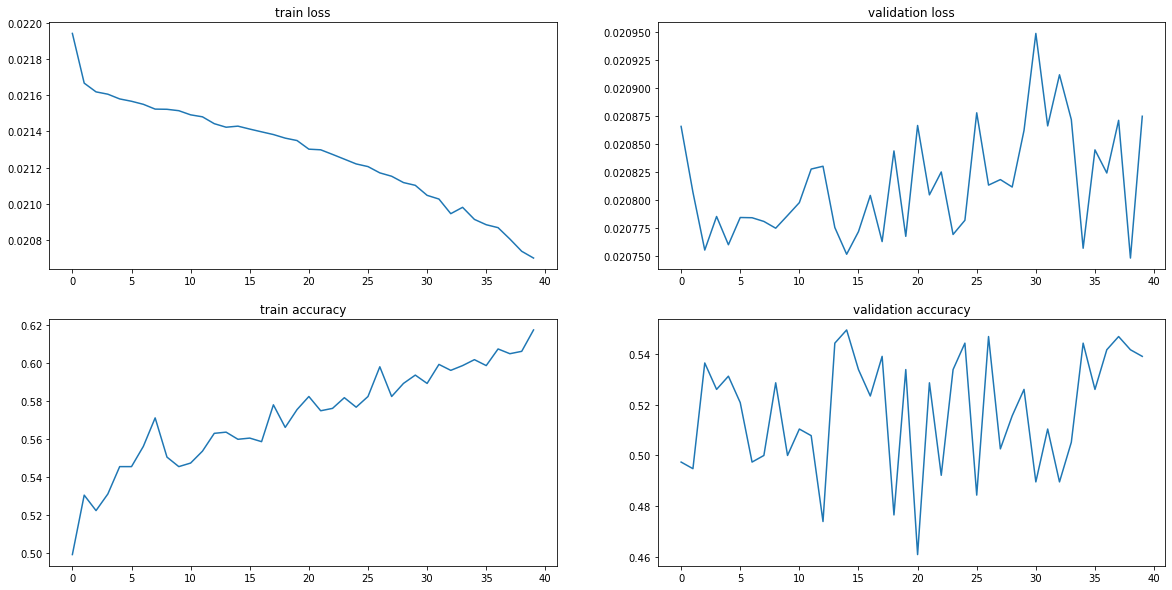

In [413]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(2, 2, 1)
ax2 = figure.add_subplot(2, 2, 2)
ax3 = figure.add_subplot(2, 2, 3)
ax4 = figure.add_subplot(2, 2, 4)

plt.title('LSTM with pretraining')
ax1.plot(total_train_loss)
ax1.set_title('train loss')
ax2.plot(total_val_loss)
ax2.set_title('validation loss')
ax3.plot(total_train_accuracy)
ax3.set_title('train accuracy')
ax4.plot(total_val_accuracy)
ax4.set_title('validation accuracy')
plt.show()


# CNN without pretraining

In [414]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_CNN_withoutPretraining = CNN(**params)
model_CNN_withoutPretraining.word_embeddings.weight.requires_grad = True #embedding weights are fixed. (not updated)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_CNN_withoutPretraining.parameters(), lr=0.1)

In [415]:
#CPU
total_time_start = time.time()

total_epoch = 40
total_train_loss= np.array([])
total_train_accuracy= np.array([])
total_val_loss=np.array([])
total_val_accuracy= np.array([])

#start_word_embeddingstime=time.time()
for epoch in range(total_epoch) :
    epoch_train_loss=0
    epoch_train_accuracy=np.array([])
    epoch_val_loss=0
    epoch_val_accuracy=np.array([])

    
    # train
    model_CNN_withoutPretraining.train()
    for batch_idx, batch in enumerate(train_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        #print(x_train.size())
        predicted_y = model_CNN_withoutPretraining(x_train).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        #print(predicted_y)    
        #print(label)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        loss.backward() # compute the gradients
        optimizer.step() # update the parameters
        epoch_train_loss += loss.item()
        acc = binary_accuracy(predicted_y, label) # to measure accuracy
        epoch_train_accuracy = np.append(epoch_train_accuracy, [acc])
        
    # validation
    model_CNN_withoutPretraining.eval()
    total_val_error=0
    for batch_idx, batch in enumerate(validation_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        predicted_y = model_CNN_withoutPretraining(x_train).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        epoch_val_loss += loss.item()   
        acc = binary_accuracy(predicted_y, label) # to measure accuracy
        epoch_val_accuracy = np.append(epoch_val_accuracy, [acc])
    
    
    total_train_loss = np.append(total_train_loss, [epoch_train_loss/len(train_loader.dataset)])
    total_train_accuracy= np.append(total_train_accuracy, [sum(epoch_train_accuracy)/len(epoch_train_accuracy)])
    total_val_loss = np.append(total_val_loss, [epoch_val_loss/len(validation_loader.dataset)])
    total_val_accuracy = np.append(total_val_accuracy, [sum(epoch_val_accuracy)/len(epoch_val_accuracy)])
    
    print("[{:02d}/{:02d}] \t loss: {:.10f}\t val_error: {:.10f}\t val_accuracy : {:10f}".format(epoch, total_epoch, epoch_train_loss / len(train_loader.dataset), epoch_val_loss / len(validation_loader.dataset), sum(epoch_val_accuracy)/len(epoch_val_accuracy)))

total_time_end = time.time()
print("total running time: ", total_time_end - total_time_start)

[00/40] 	 loss: 0.0224772106	 val_error: 0.0207691771	 val_accuracy :   0.513021
[01/40] 	 loss: 0.0216949090	 val_error: 0.0207638896	 val_accuracy :   0.518229
[02/40] 	 loss: 0.0216878074	 val_error: 0.0207844830	 val_accuracy :   0.507812
[03/40] 	 loss: 0.0216820397	 val_error: 0.0207927173	 val_accuracy :   0.507812
[04/40] 	 loss: 0.0216721569	 val_error: 0.0208014692	 val_accuracy :   0.505208
[05/40] 	 loss: 0.0216764040	 val_error: 0.0207843956	 val_accuracy :   0.507812
[06/40] 	 loss: 0.0216463618	 val_error: 0.0207735142	 val_accuracy :   0.515625
[07/40] 	 loss: 0.0216543081	 val_error: 0.0207825869	 val_accuracy :   0.523438
[08/40] 	 loss: 0.0216249303	 val_error: 0.0207628675	 val_accuracy :   0.518229
[09/40] 	 loss: 0.0216806368	 val_error: 0.0207730876	 val_accuracy :   0.515625
[10/40] 	 loss: 0.0216326911	 val_error: 0.0209944838	 val_accuracy :   0.492188
[11/40] 	 loss: 0.0216462272	 val_error: 0.0207739969	 val_accuracy :   0.523438
[12/40] 	 loss: 0.0215950850

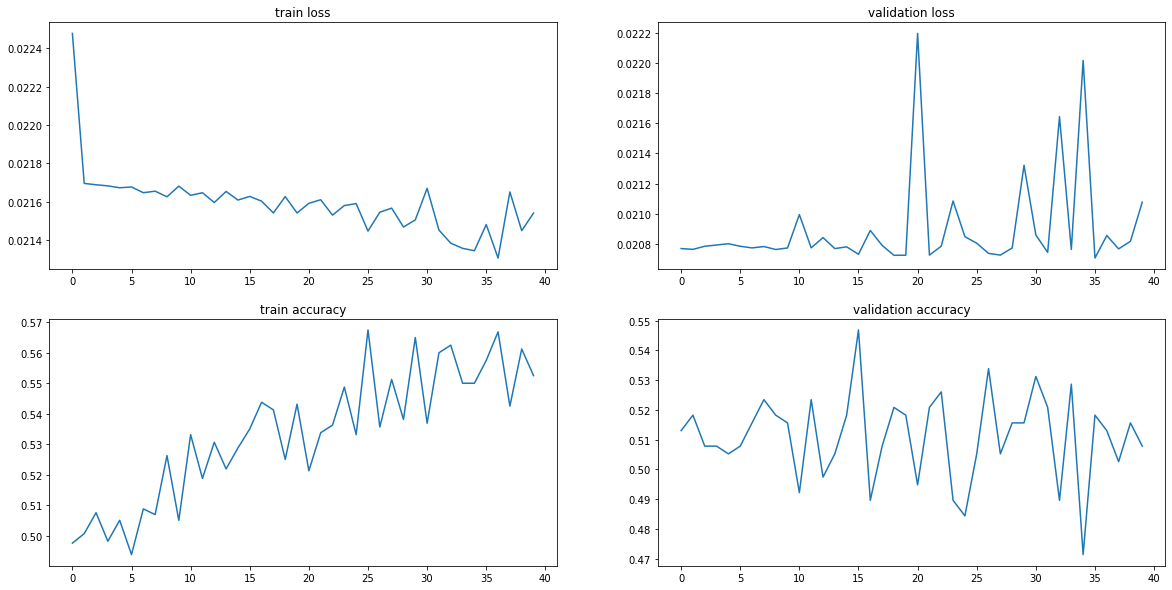

In [416]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(2, 2, 1)
ax2 = figure.add_subplot(2, 2, 2)
ax3 = figure.add_subplot(2, 2, 3)
ax4 = figure.add_subplot(2, 2, 4)

plt.title('LSTM with pretraining')
ax1.plot(total_train_loss)
ax1.set_title('train loss')
ax2.plot(total_val_loss)
ax2.set_title('validation loss')
ax3.plot(total_train_accuracy)
ax3.set_title('train accuracy')
ax4.plot(total_val_accuracy)
ax4.set_title('validation accuracy')
plt.show()


# RNN with pretraining

In [417]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RNN_net_pretrain(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, sentence_length, batch_size=32, num_layers=1, label_size=2):
        super(RNN_net_pretrain, self).__init__()
        self.pad_index = word_to_ix['<pad>']
        self.word_embeddings = nn.Embedding(embedding_dim, hidden_dim, padding_idx=self.pad_index)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sentence_length = sentence_length
        self.batch_size = batch_size
        self.num_layers = num_layers
        #[sequence length, batch size, embedding_dim (input_size)]
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        
        # The linear layer that maps from hidden state space to label space
        self.hidden2label = nn.Linear(self.sentence_length*self.hidden_dim, label_size)

    def forward(self, sentence):
        #print("sentence size", sentence.size())
        embeds = self.word_embeddings(sentence)
        #print("embed size", embeds.size())
        #print(embeds.view(self.batch_size, len(sentence), self.embedding_dim).size())
        hidden = torch.randn(self.num_layers, self.batch_size, self.hidden_dim)
        #print("hidden", hidden.size())
        # input : [batch_size, sequence_length, embedding_dim (input_size)]
        # hidden : [num_layers, batch_size, hidden_size]
        out, hidden = self.rnn(embeds, hidden) #2nd output is the final hidden state
        #out, hidden = self.rnn(embeds.view(self.batch_size,embeds.size(1), self.embedding_dim), hidden) #2nd output is the final hidden state
        #print(out[-2,:,:].size(), out[-1,:,:].size())
        #out = torch.cat((out[1], out[2]), dim=1)
        #out = out.view(out.size(0), 1, out.size(1)*out.size(2))
        out = torch.reshape(out, (out.size(0), 1, out.size(1)*out.size(2)))
        #print("out.size:", out.size())
        label_space = self.hidden2label(out)
        #return(label_space.flatten())
        
        #print("label_space:", label_space.size())
        #label_scores = F.log_softmax(label_space, dim=1)
        #label_scores = F.sigmoid(label_space)
        #label_scores = torch.reshape(label_scores, (-1,2))
        #print(label_scores.size())
        label_scores = torch.reshape(label_space, (-1,2))
        return label_scores
        #return label_scores.flatten(start_dim=1)
        #print("label_scores:", label_scores.size())
        #return torch.argmax(label_scores)

In [440]:
class LSTM_net(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, sentence_length, batch_size=32, num_layers=7, label_size=2):
        super(LSTM_net, self).__init__()
        self.pad_index = word_to_ix['<pad>']
        self.word_embeddings = nn.Embedding(embedding_dim, hidden_dim, padding_idx=self.pad_index).to(device)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.sentence_length = sentence_length
        self.batch_size = batch_size
        self.num_layers = num_layers
        #[sequence length, batch size, embedding_dim (input_size)]
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        
        # The linear layer that maps from hidden state space to label space
        self.hidden2label = nn.Linear(self.sentence_length*self.hidden_dim, label_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence.to(device))
        #print(embeds.view(self.batch_size, len(sentence), self.embedding_dim).size())
        h0 = torch.randn(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        c0 = torch.randn(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        #print("hidden", hidden.size())
        # input : [batch_size, sequence_length, embedding_dim (input_size)]
        # hidden : [num_layers, batch_size, hidden_size]
        out, out_hidden = self.lstm(embeds, (h0,c0)) #2nd output is the final hidden state
        out = torch.reshape(out, (out.size(0), 1, out.size(1)*out.size(2)))
        #print("out.size:", out.size())
        label_space = self.hidden2label(out)
        #return(label_space.flatten())
        
        #print("label_space:", label_space.size())
        #label_scores = F.log_softmax(label_space, dim=1)
        #label_scores = F.sigmoid(label_space)
        #label_scores = torch.reshape(label_scores, (-1,2))
        #print(label_scores.size())
        label_scores = torch.reshape(label_space, (-1,2))
        return label_scores
        #return label_scores.flatten(start_dim=1)
        #print("label_scores:", label_scores.size())
        #return torch.argmax(label_scores)

In [441]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model_RNN = LSTM_net(100, 300, 1000, batch_size=32)
# model_RNN.word_embeddings.weight.data = torch.FloatTensor(embedding_matrix)
# model_RNN.word_embeddings.weight.requires_grad = False #embedding weights are fixed. (not updated)
# loss_function = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_RNN.parameters(), lr=0.1)


In [446]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_RNN_gpu = LSTM_net(100, 300, 1000, batch_size=32).to(device)
model_RNN_gpu.word_embeddings.weight.data = torch.FloatTensor(embedding_matrix).to(device)
model_RNN_gpu.word_embeddings.weight.requires_grad = False #embedding weights are fixed. (not updated)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_RNN_gpu.parameters(), lr=0.1)


In [447]:
# #CPU
# total_time_start = time.time()

# total_epoch = 100
# total_train_loss= np.array([])
# total_train_accuracy= np.array([])
# total_val_loss=np.array([])
# total_val_accuracy= np.array([])

# #start_word_embeddingstime=time.time()
# for epoch in range(total_epoch) :
#     epoch_train_loss=0
#     epoch_train_accuracy=np.array([])
#     epoch_val_loss=0
#     epoch_val_accuracy=np.array([])

    
#     # train
#     model_RNN.train()
#     for batch_idx, batch in enumerate(train_loader) :
#         optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
#         x_train, label = batch
#         #print(x_train.size())
#         predicted_y = model_RNN(x_train).type(torch.FloatTensor)
#         label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
#         #print(predicted_y)    
#         #print(label)
#         loss = loss_function(predicted_y, label_onehot) # compute the loss
#         loss.backward() # compute the gradients
#         optimizer.step() # update the parameters
#         epoch_train_loss += loss.item()
#         acc = binary_accuracy(predicted_y, label) # to measure accuracy
#         epoch_train_accuracy = np.append(epoch_train_accuracy, [acc])
        
#     # validation
#     model_RNN.eval()
#     total_val_error=0
#     for batch_idx, batch in enumerate(validation_loader) :
#         optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
#         x_train, label = batch
#         predicted_y = model_RNN(x_train).type(torch.FloatTensor)
#         label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
#         loss = loss_function(predicted_y, label_onehot) # compute the loss
#         epoch_val_loss += loss.item()   
#         acc = binary_accuracy(predicted_y, label) # to measure accuracy
#         epoch_val_accuracy = np.append(epoch_val_accuracy, [acc])
    
#     total_train_loss = np.append(total_train_loss, [epoch_train_loss/len(train_loader.dataset)])
#     total_train_accuracy= np.append(total_train_accuracy, [sum(epoch_train_accuracy)/len(epoch_train_accuracy)])
#     total_val_loss = np.append(total_val_loss, [epoch_val_loss/len(validation_loader.dataset)])
#     total_val_accuracy = np.append(total_val_accuracy, [sum(epoch_val_accuracy)/len(epoch_val_accuracy)])
    
#     print("[{:02d}/{:02d}] \t loss: {:.10f}\t val_error: {:.10f}\t val_accuracy : {:10f}".format(epoch, total_epoch, epoch_train_loss / len(train_loader.dataset), epoch_val_loss / len(validation_loader.dataset), sum(epoch_val_accuracy)/len(epoch_val_accuracy)))
    
# total_time_end = time.time()
# print("total running time: ", total_time_end - total_time_start)

In [462]:
#GPU
total_time_start = time.time()

total_epoch = 100
total_train_loss= np.array([])
total_train_accuracy= np.array([])
total_val_loss=np.array([])
total_val_accuracy= np.array([])

model_RNN = model_RNN_gpu
#start_word_embeddingstime=time.time()
for epoch in range(total_epoch) :
    epoch_train_loss=0
    epoch_train_accuracy=np.array([])
    epoch_val_loss=0
    epoch_val_accuracy=np.array([])

    
    # train
    model_RNN.train()
    for batch_idx, batch in enumerate(train_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        x_train, label = x_train.to(device), label.to(device)
        #print(x_train.size())
        predicted_y = model_RNN(x_train).type(torch.FloatTensor)
        #print(predicted_y.device) #cpu
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        #print(predicted_y)    
        #print(label)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        loss.backward() # compute the gradients
        optimizer.step() # update the parameters
        epoch_train_loss += loss.item()
        acc = binary_accuracy(predicted_y, label.to('cpu')) # to measure accuracy
        epoch_train_accuracy = np.append(epoch_train_accuracy, [acc])
        
    # validation
    model_RNN.eval()
    total_val_error=0
    for batch_idx, batch in enumerate(validation_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        x_train, label = x_train.to(device), label.to(device)
        predicted_y = model_RNN(x_train.to(device)).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        loss = loss_function(predicted_y.to('cpu'), label_onehot.to('cpu')) # compute the loss
        epoch_val_loss += loss.item()   
        acc = binary_accuracy(predicted_y, label.to('cpu')) # to measure accuracy
        epoch_val_accuracy = np.append(epoch_val_accuracy, [acc])
    
    total_train_loss = np.append(total_train_loss, [epoch_train_loss/len(train_loader.dataset)])
    total_train_accuracy= np.append(total_train_accuracy, [sum(epoch_train_accuracy)/len(epoch_train_accuracy)])
    total_val_loss = np.append(total_val_loss, [epoch_val_loss/len(validation_loader.dataset)])
    total_val_accuracy = np.append(total_val_accuracy, [sum(epoch_val_accuracy)/len(epoch_val_accuracy)])
    
    print("[{:02d}/{:02d}] \t loss: {:.10f}\t val_error: {:.10f}\t val_accuracy : {:10f}".format(epoch, total_epoch, epoch_train_loss / len(train_loader.dataset), epoch_val_loss / len(validation_loader.dataset), sum(epoch_val_accuracy)/len(epoch_val_accuracy)))
    
total_time_end = time.time()
print("total running time: ", total_time_end - total_time_start)

[00/100] 	 loss: 0.0217550174	 val_error: 0.0209977221	 val_accuracy :   0.466146
[01/100] 	 loss: 0.0217528928	 val_error: 0.0207561427	 val_accuracy :   0.541667
[02/100] 	 loss: 0.0217072032	 val_error: 0.0208958587	 val_accuracy :   0.460938
[03/100] 	 loss: 0.0216928694	 val_error: 0.0207500450	 val_accuracy :   0.513021
[04/100] 	 loss: 0.0217670039	 val_error: 0.0205499831	 val_accuracy :   0.572917
[05/100] 	 loss: 0.0217572761	 val_error: 0.0208937526	 val_accuracy :   0.479167
[06/100] 	 loss: 0.0216639087	 val_error: 0.0207959388	 val_accuracy :   0.510417
[07/100] 	 loss: 0.0216214464	 val_error: 0.0208272682	 val_accuracy :   0.502604
[08/100] 	 loss: 0.0217884298	 val_error: 0.0207942465	 val_accuracy :   0.510417
[09/100] 	 loss: 0.0217902565	 val_error: 0.0207017130	 val_accuracy :   0.533854
[10/100] 	 loss: 0.0217103751	 val_error: 0.0209117019	 val_accuracy :   0.518229
[11/100] 	 loss: 0.0217853710	 val_error: 0.0208831576	 val_accuracy :   0.489583
[12/100] 	 loss:

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(2, 2, 1)
ax2 = figure.add_subplot(2, 2, 2)
ax3 = figure.add_subplot(2, 2, 3)
ax4 = figure.add_subplot(2, 2, 4)

plt.title('LSTM with pretraining')
ax1.plot(total_train_loss)
ax1.set_title('train loss')
ax2.plot(total_val_loss)
ax2.set_title('validation loss')
ax3.plot(total_train_accuracy)
ax3.set_title('train accuracy')
ax4.plot(total_val_accuracy)
ax4.set_title('validation accuracy')
plt.show()


In [ ]:
# Disable grad
batch_size = 32

total_prediction = np.array([], dtype=np.int64)
total_prediction_index = np.array([], dtype=np.int64)
with torch.no_grad():
    for index, batch in enumerate(test_loader):
        x_test, x_index = batch
        #print(x_test)
        #print(x_test.size())
        
        # for last incomplete batch,
        if (x_test.size(0) < batch_size) :
            num_padding = batch_size - x_test.size(0)
            print("the last incomplete padding : ", num_padding)
            padding = torch.zeros(num_padding, max_length)
            x_test = torch.cat((x_test, padding), dim=0)
        pred = model_RNN(x_test.type(torch.int))
        #print(torch.argmax(pred, dim=1))
        array = torch.argmax(pred, dim=1).numpy()
        array_index = x_index.numpy()
        #print(array.dtype)
        if index == 0:
            total_prediction = array
            total_prediction_index = array_index
        else:
            total_prediction = np.concatenate((total_prediction, array), axis=0)
            total_prediction_index = np.concatenate((total_prediction_index, array_index), axis=0)
            #print(total_prediction)

total_prediction=total_prediction[0:2000]
total_prediction_index=total_prediction_index[0:2000]
print(total_prediction.shape)
print(total_prediction_index.shape)

In [ ]:
# write csv file
import csv

header = ['id', 'sentiment']

f = open('/home/jihun/python/predict.csv', 'w') # open the file in the write mode
writer = csv.writer(f) # create the csv writer
writer.writerow(header) # write a row to the csv file

for k in range(2000):
    row = [total_prediction_index[k], total_prediction[k]]
    writer.writerow(row)
f.close() # close the file


# RNN without pretraining

In [ ]:
model_RNN_noPre.word_embeddings.weight

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_RNN_noPre = LSTM_net(100, 100, 200, batch_size=32)
model_RNN_noPre.word_embeddings.weight.data = torch.FloatTensor(torch.rand(embedding_matrix.shape[0],embedding_matrix.shape[1]))
model_RNN_noPre.word_embeddings.weight.requires_grad = True #embedding weights are fixed. (not updated)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_RNN_noPre.parameters(), lr=0.1)

In [ ]:
#CPU
total_time_start = time.time()

total_epoch = 100
total_train_loss= np.array([])
total_train_accuracy= np.array([])
total_val_loss=np.array([])
total_val_accuracy= np.array([])

#start_word_embeddingstime=time.time()
for epoch in range(total_epoch) :
    epoch_train_loss=0
    epoch_train_accuracy=np.array([])
    epoch_val_loss=0
    epoch_val_accuracy=np.array([])

    
    # train
    model_RNN_noPre.train()
    for batch_idx, batch in enumerate(train_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        #print(x_train.size())
        predicted_y = model_RNN_noPre(x_train).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        #print(predicted_y)    
        #print(label)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        loss.backward() # compute the gradients
        optimizer.step() # update the parameters
        epoch_train_loss += loss.item()
        acc = binary_accuracy(predicted_y, label) # to measure accuracy
        epoch_train_accuracy = np.append(epoch_train_accuracy, [acc])
        
    # validation
    model_RNN_noPre.eval()
    total_val_error=0
    for batch_idx, batch in enumerate(validation_loader) :
        optimizer.zero_grad() # to clear gradient #cf. model.zero_grad()
        x_train, label = batch
        predicted_y = model_RNN_noPre(x_train).type(torch.FloatTensor)
        label_onehot = F.one_hot(label, num_classes=2).type(torch.FloatTensor)
        loss = loss_function(predicted_y, label_onehot) # compute the loss
        epoch_val_loss += loss.item()   
        acc = binary_accuracy(predicted_y, label) # to measure accuracy
        epoch_val_accuracy = np.append(epoch_val_accuracy, [acc])
    
    total_train_loss = np.append(total_train_loss, [epoch_train_loss/len(train_loader.dataset)])
    total_train_accuracy= np.append(total_train_accuracy, [sum(epoch_train_accuracy)/len(epoch_train_accuracy)])
    total_val_loss = np.append(total_val_loss, [epoch_val_loss/len(validation_loader.dataset)])
    total_val_accuracy = np.append(total_val_accuracy, [sum(epoch_val_accuracy)/len(epoch_val_accuracy)])
    
    print("[{:02d}/{:02d}] \t loss: {:.10f}\t val_error: {:.10f}\t val_accuracy : {:10f}".format(epoch, total_epoch, epoch_train_loss / len(train_loader.dataset), epoch_val_loss / len(validation_loader.dataset), sum(epoch_val_accuracy)/len(epoch_val_accuracy)))
    
total_time_end = time.time()
print("total running time: ", total_time_end - total_time_start)

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(2, 2, 1)
ax2 = figure.add_subplot(2, 2, 2)
ax3 = figure.add_subplot(2, 2, 3)
ax4 = figure.add_subplot(2, 2, 4)

plt.title('LSTM with pretraining')
ax1.plot(total_train_loss)
ax1.set_title('train loss')
ax2.plot(total_val_loss)
ax2.set_title('validation loss')
ax3.plot(total_train_accuracy)
ax3.set_title('train accuracy')
ax4.plot(total_val_accuracy)
ax4.set_title('validation accuracy')
plt.show()
